In [1]:
import numpy as np
import tensorflow
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
EPOCHS = 50
INIT_LR = 0.01
BS = 64
default_image_size = tuple((128,128))
image_size = 0
directory_root = '/kaggle/input/coffee'
width = 128
height = 128
depth = 3
inputShape=(height,width,depth)

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:3000]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".jpeg") == True or image_directory.endswith(".JPEG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing Miner ...
[INFO] Processing Leaf rust ...
[INFO] Processing Cerscospora ...
[INFO] Processing Phoma ...
[INFO] Processing Healthy ...
[INFO] Image loading completed


In [4]:
image_size = len(image_list)
image_size

15000

In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Cerscospora' 'Healthy' 'Leaf rust' 'Miner' 'Phoma']


In [6]:
np_image_list = np.array(image_list, dtype=np.float16) / 225
print("[INFO] Spliting data to train, test")
X_train, x_test, Y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)
x_val = len(X_train)
x_testval = len(x_test)
y_val = len(Y_train)
y_testval = len(y_test)

x_val, x_testval, y_val, y_testval

[INFO] Spliting data to train, test


(12000, 3000, 12000, 3000)

In [7]:
train_datagen = ImageDataGenerator (rotation_range=45, width_shift_range=0.4, 
                                    height_shift_range=0.3, shear_range=0.4, zoom_range=0.5, 
                                    fill_mode='nearest', horizontal_flip=True,validation_split=0.2)


In [8]:
def Res_Plot_Test_Save(name):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
    
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")

In [9]:
import keras
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16

model = Sequential()
model.add(VGG16(include_top=False, weights='imagenet',input_shape=inputShape))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

opt = Adam(learning_rate = INIT_LR, decay=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 18,975,813
Trainable params: 18,975,813
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(train_datagen.flow(X_train, Y_train, batch_size=BS), validation_data=(x_test, y_test), 
                    steps_per_epoch = len(X_train) // BS, epochs = EPOCHS, verbose = 1)

Epoch 1/50
187/187 [==============================] - 70s 319ms/step - loss: 478334656.0000 - accuracy: 0.4133 - val_loss: 0.3047 - val_accuracy: 0.6263
Epoch 2/50
187/187 [==============================] - 55s 291ms/step - loss: 0.2847 - accuracy: 0.6504 - val_loss: 0.2633 - val_accuracy: 0.6960
Epoch 3/50
187/187 [==============================] - 54s 291ms/step - loss: 0.2583 - accuracy: 0.6950 - val_loss: 0.2430 - val_accuracy: 0.7343
Epoch 4/50
187/187 [==============================] - 54s 290ms/step - loss: 0.2487 - accuracy: 0.7114 - val_loss: 0.2339 - val_accuracy: 0.7343
Epoch 5/50
187/187 [==============================] - 54s 291ms/step - loss: 0.2400 - accuracy: 0.7275 - val_loss: 0.2239 - val_accuracy: 0.7597
Epoch 6/50
187/187 [==============================] - 54s 289ms/step - loss: 0.2344 - accuracy: 0.7310 - val_loss: 0.2177 - val_accuracy: 0.7787
Epoch 7/50
187/187 [==============================] - 54s 290ms/step - loss: 0.2303 - accuracy: 0.7412 - val_loss: 0.2134 

[INFO] Plotting model accuracy and Loss


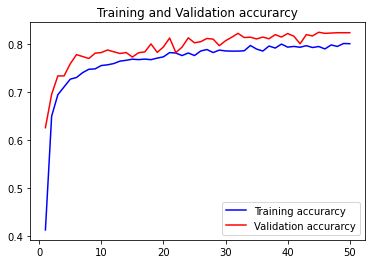

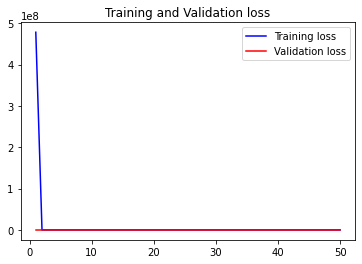

[INFO] Calculating model accuracy
94/94 [==============================] - 2s 23ms/step - loss: 0.1788 - accuracy: 0.8243
Test Accuracy: 82.43333101272583


In [11]:
Res_Plot_Test_Save('VGG16.h5')